This project is about Deep Learning and image analysis. It use Python as language, Tensorflow and Keras to build the model and matplotlib to visualize performance metrics.

The goal is to create a model that can predict if the image contains a plane. The dataset, available on Kaggle consist of 8000 images with a plane on it and 24000 without.

The images are 20x20 pixel squares and each pixel équals to 3 meters in reality. The data are stored in a JSON file organized chanel by chanel.
One array for each color (red, green and blue)

Source : https://www.kaggle.com/datasets/rhammell/planesnet

Package

In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

I load the JSON file with a generator while reshaping and normalizing the data.

Reshaping is necessary because its easier to display image when they are in pixel by pixel format and not chanel by chanel.

I choose to load the JSON file with a generator because I'm using Tensorflow to build the model. Tensorflow is more efficient when it works with Tensor dataset.

So i have to transform the JSON file into a Tensor Dataset. The proper way to do that is to load the file with a generator and to use the .from_generator() method.

In [6]:
chemin_fichier = "archive/planesnet.json"
# Generator function to load data from JSON file
def chargement_fichier(nom_fichier=chemin_fichier):
    with open(nom_fichier, 'r') as fichier:
            json_data = json.load(fichier)
            for image,etiquette in zip(json_data['data'],json_data['labels'] ):# extracting images and labels
                yield np.transpose(np.array(image).reshape(3,20,20),(1,2,0)),etiquette #Reshaping 
            
generator = chargement_fichier(chemin_fichier)

# Create TensorFlow Dataset from the generator
dataset = tf.data.Dataset.from_generator(
    chargement_fichier,
    output_signature=(
        tf.TensorSpec(shape=(20,20,3), dtype=tf.float32,name="Image"), 
        tf.TensorSpec(shape=(), dtype=tf.int32,name="etiquette")       
    ))

def pack_row(*row):
  image = row[0]
  etiquette = row[1]
  return image, etiquette

packed_dataset = dataset.batch(400).map(pack_row).unbatch()

I store lots of metrics related to the model.

To balance the rate of plane images, I oversample the dataset. I just copy the plane images to have the same amount of plane images and non-plane images.

I will apply random transformations during training to prevent over-fitting.

The shuffle is extremely important because without it the model will train only with plane images and evaluate with non-plane images.

I split data into validation and train sets. I use the cache method to let the dataset in memory and I pack the dataset into batches.

The two datasets are now ready and optimized.


In [7]:
N_TOTAL=32000
val_rate=0.3
N_VALIDATION = int(N_TOTAL*val_rate)
N_TRAIN = N_TOTAL - N_VALIDATION
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 32
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
N_PLANE=8000

#Oversampling
plane_dataset= packed_dataset.filter(lambda etiquette, y: tf.equal(y, 1))
no_plane_dataset= packed_dataset.filter(lambda etiquette, y: tf.equal(y, 0))
N_repeat= (N_TOTAL-N_PLANE)//N_PLANE
plane_ds_oversampled = plane_dataset.repeat(N_repeat)
#We concatenate the oversampled plane dataset with the no plane dataset
packed_dataset = no_plane_dataset.concatenate(plane_ds_oversampled)
count = sum(1 for _ in packed_dataset)
#We shuffle the dataset
packed_dataset = packed_dataset.shuffle(count)

N_VALIDATION = int(count*val_rate)
N_TRAIN = N_TOTAL - N_VALIDATION


#Split into validation and train datasets
validation_dataset = packed_dataset.take(int(N_VALIDATION)).cache().batch(BATCH_SIZE)
train_dataset = packed_dataset.skip(int(N_VALIDATION)).take(int(N_TRAIN)).cache().batch(BATCH_SIZE)

KeyboardInterrupt: 

We display some images to show how it looks.

In [ ]:
label={0:"No plane",1:"Plane"}
plt.figure(figsize=(15,5))
i=0
for image_batch, label_batch in validation_dataset.unbatch().take(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image_batch.numpy().astype("uint8"))
    plt.title(label.get(label_batch.numpy()))
    i += 1
plt.show()

NameError: name 'plt' is not defined

I create a Convolutionnal Neural Network (CNN) to predict the label. 
The model normalize the data because neural networks perform better with value between 0 and 1.
The model apply random transformation such as flip or rotation as i mentionned before.
I add a layers (convolution,dense) and a dropout to prevent over-fitting.
The model predict a binary value so the last layer have the sigmoid activation function. 
The model output the probability that an image contains a plane

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(20, 20, 3)),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Conv2D(16, 2, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

C:\Users\fbjrm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


I compile the model with the optimizer, the loss function and the metrics. Adam is the more commun optimizer thats why i use him. The loss is the binary cross entropy, also very commun with binary labels. 

Precision is important to show because it representsthe percentage of correctly identified plane images among all images predicted as containing a plane. In contrast, accuracy measures the overall percentage of correct predictions, including both plane and non-plane images.

This approach prioritizes safety ensuring that potential planes are flagged even at the risk of occasional false alarms.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy','precision'])

I display the summary of the model.


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 20, 20, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 20, 20, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,737 (401.32 KB)

 Trainable params: 102,737 (401.32 KB)

 Non-trainable params: 0 (0.00 B)

The model is small with few parameters so I can run between 25 and 50 epochs.

In [ ]:
epochs=25

history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/25
    549/Unknown 47s 4ms/step - accuracy: 0.6201 - loss: 0.6301 - precision: 0.6028

C:\Users\fbjrm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


550/550 ━━━━━━━━━━━━━━━━━━━━ 91s 85ms/step - accuracy: 0.7208 - loss: 0.5346 - precision: 0.6889 - val_accuracy: 0.8613 - val_loss: 0.3770 - val_precision: 0.8035
Epoch 2/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8649 - loss: 0.3420 - precision: 0.8422 - val_accuracy: 0.8685 - val_loss: 0.3150 - val_precision: 0.8041
Epoch 3/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8945 - loss: 0.2793 - precision: 0.8729 - val_accuracy: 0.8956 - val_loss: 0.2590 - val_precision: 0.8419
Epoch 4/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9052 - loss: 0.2447 - precision: 0.8878 - val_accuracy: 0.9076 - val_loss: 0.2253 - val_precision: 0.8600
Epoch 5/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9147 - loss: 0.2251 - precision: 0.9018 - val_accuracy: 0.9253 - val_loss: 0.1942 - val_precision: 0.8971
Epoch 6/25
550/550 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9184 - loss: 0.2108 - precision: 0.9062 - val_accuracy: 0.9302 - val_loss: 0.1831 -

I plot the metrics during training and validation.

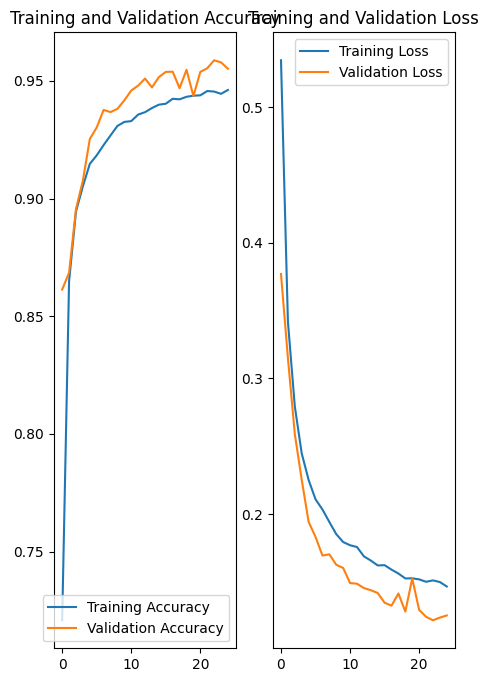

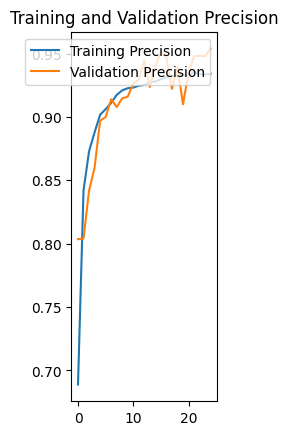

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, precision, label='Training Precision')
plt.plot(epochs_range, val_precision, label='Validation Precision')
plt.legend(loc='upper right')
plt.title('Training and Validation Precision')
plt.show()

We observe that the loss has not yet plateaued, indicating that the model could benefit from additional training epochs. However, further training may not be necessary, as the model already performs well on both the training and validation sets.

With a precision and accuracy of 95%, the model demonstrates strong performance in detecting planes.

Here is the result of the prediction on the validation set.

450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


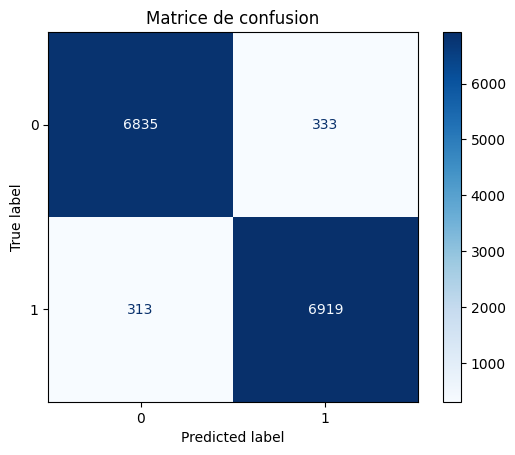

[0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 

In [ ]:
#Put validation data into numpy arrays
X_val_np = []
y_val_np = []
for feature,label in validation_dataset.unbatch():
    X_val_np.append(feature.numpy())
    y_val_np .append(int(label))
X_val_np = np.array(X_val_np)

#Prediction by the model
y_pred_probs = model.predict(X_val_np)
y_pred_classes = [1 if prob > 0.5 else 0 for prob in y_pred_probs]

#Calculating the confusion matrix
cm = confusion_matrix(y_val_np, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


We can see on the confusion matrix that the model is very performant in distinguishing a plane on a satellite images.
I show the two new image, one with plane and the other without.

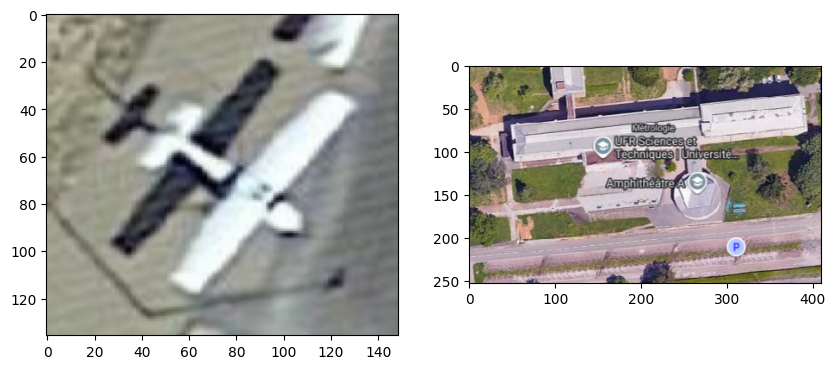

In [ ]:
test_img1=Image.open("plane_detection/new_data/gray_plane.png").convert("RGB")
test_img2=Image.open("plane_detection/new_data/universite.png").convert("RGB")
plt.figure(figsize=(10,5))
i=1
for img in [test_img1,test_img2]:
    plt.subplot(1, 2, i)
    plt.imshow(img)
    i+=1
plt.show()

I change the size of the images to have the same as the images used to train and validate the model.
I use the model to predict if there is a plane on the image.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


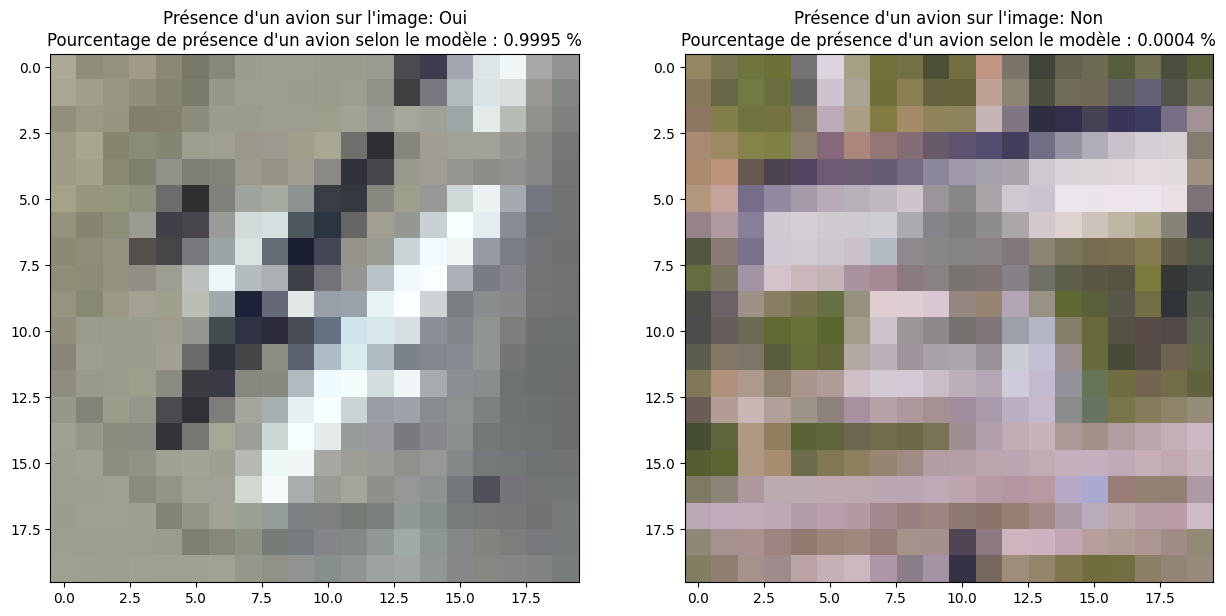

In [ ]:

test_img1 = test_img1.resize((20, 20))
test_img1_array = np.array(test_img1)

test_img2 = test_img2.resize((20, 20))
test_img2_array = np.array(test_img2)
plt.figure(figsize=(15,8))
i=1
for img,label in zip([test_img1_array,test_img2_array],["Yes","No"]):
    prediction = model.predict(img.reshape(1,20,20,3))
    avion="Oui" if prediction[0][0]>0.5 else "Non"
    
    plt.subplot(1, 2, i)
    plt.imshow(img)
    plt.title(f"Plane on the image: {label}"+f"\nProbability of plane according to the model : {np.round(float(prediction[0][0]),4)} %")
    i+=1
plt.show()



We can see that the model predict well on the two images.